# Residual in vector regression

Usually, one predicts only one target variable from avaliable imputs. However, there are other tasks where you are interested in predicting several outputs:

* texture synthesis based on the borders
* trajectory prediction for cars and pedestrians

In the following, we show that this task is conceptually different from doing several predictions in parallel. For that we a considering prediction of an RGB pixel from its direct neighbours. We solve the task using ordinary linear regression described in the notbook [02_texture_synthesis.ipynb](./02_texture_synthesis.ipynb). See that for further details. 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

# Local imports
from common import *
from convenience import *

## I. Challenge textures

* Again we use images of bark and moss as templates for textures. 
* But now we try to predict all color channels at the same time.
* Note that the bark texture is more monochromatic than the moss texture.  

In [5]:
# Let us extract 500 x 500 subimages
bark = plt.imread('data/texture/bark.png')[:500, :500, :]
moss = plt.imread('data/texture/moss.png')[:500, :500, :]

In [6]:
moss

array([[[0.04705882, 0.12941177, 0.00784314, 1.        ],
        [0.03137255, 0.09803922, 0.        , 1.        ],
        [0.01960784, 0.05098039, 0.        , 1.        ],
        ...,
        [0.2627451 , 0.28627452, 0.        , 1.        ],
        [0.54509807, 0.5921569 , 0.12941177, 1.        ],
        [0.5803922 , 0.627451  , 0.10980392, 1.        ]],

       [[0.07843138, 0.15686275, 0.01960784, 1.        ],
        [0.02745098, 0.09411765, 0.        , 1.        ],
        [0.01960784, 0.05882353, 0.        , 1.        ],
        ...,
        [0.39215687, 0.40392157, 0.06666667, 1.        ],
        [0.4862745 , 0.5254902 , 0.05098039, 1.        ],
        [0.4627451 , 0.49803922, 0.        , 1.        ]],

       [[0.15294118, 0.22352941, 0.05882353, 1.        ],
        [0.0627451 , 0.12941177, 0.        , 1.        ],
        [0.        , 0.03529412, 0.        , 1.        ],
        ...,
        [0.52156866, 0.50980395, 0.12941177, 1.        ],
        [0.5254902 , 0.537254

In [ ]:
# Let us define gray-scale images through the luminocity conversion
bw_bark = convert_to_grayscale(bark)
bw_moss = convert_to_grayscale(moss)

fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 2, 1)
plt.imshow(bark)
fig.add_subplot(2, 2, 2)
plt.imshow(bw_bark, cmap='gray')
fig.add_subplot(2, 2, 3)
plt.imshow(moss)
fig.add_subplot(2, 2, 4)
plt.imshow(bw_moss, cmap='gray')
plt.show()

AssertionError: Image must be m x n x 3 dimensional RGB array

* Let us visualise all three colour channels of the moss image. 
* Each of them is given as $500 \times 500$ matrix inside the image structure.
* For visual clarity we show them in grayscale and in color by muting other channels.
* On can clearly see that the blue channel differs significantly from red and green channels.

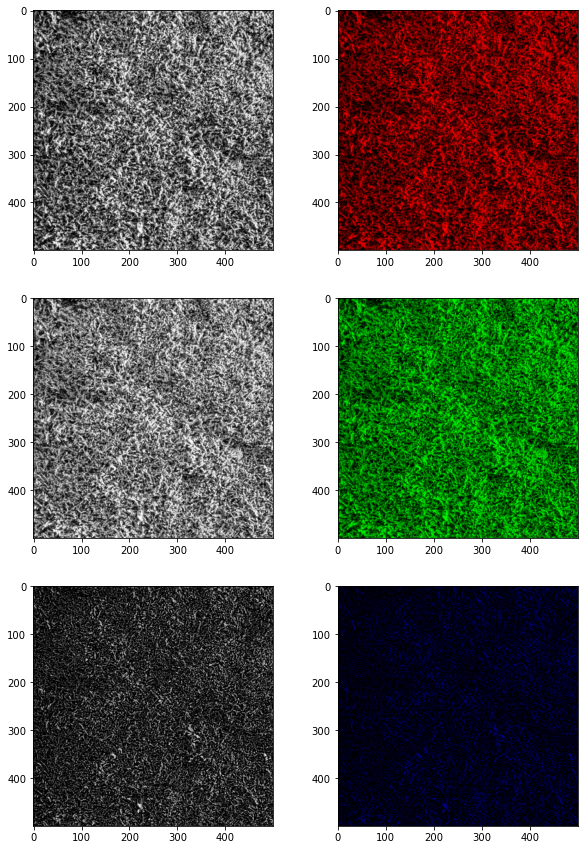

In [3]:
fig=plt.figure(figsize=(10,15))

# Red channel
fig.add_subplot(3, 2, 1)
plt.imshow(moss[:, :, 0], cmap='gray')

# Red channel + muted Blue and Green channel
fig.add_subplot(3, 2, 2)
im = np.zeros((500, 500, 3))
im[:, :, 0] = moss[:,:,0]
plt.imshow(im)

# Green channel
fig.add_subplot(3, 2, 3)
plt.imshow(moss[:, :, 1], cmap='gray')

# Green channel + muted Red and Blue channel
fig.add_subplot(3, 2, 4)
im = np.zeros((500, 500, 3))
im[:, :, 1] = moss[:,:,1]
plt.imshow(im)

# Blue channel
fig.add_subplot(3, 2, 5)
plt.imshow(moss[:, :, 2], cmap='gray')

# Blue channel + muted Red and Green channel
fig.add_subplot(3, 2, 6)
im = np.zeros((500, 500, 3))
im[:, :, 2] = moss[:,:,2]
plt.imshow(im)

plt.show()


## II. Training data collection

* Let us use the simplest $3 \times 3$ neighbourhoods for the prediction of the center pixel.
* As a trainingset we sample 5000 patches from random locations.
* For simplicity, we do not use other color channels to predict the particular color.  

In [4]:
# Sampling parameters
d = 1
m = 500
n = 500
r = 5000

# Let us sample centers of texture patches 
xm = np.random.choice(range(d, m - d), size=r, replace = True)
ym = np.random.choice(range(d, n - d), size=r, replace = True)

models = {}
channels = ['R', 'G', 'B']
residuals = DataFrame(np.full([r,3], np.nan), columns=channels)
for ix, channel in enumerate(channels):
    df = extract_texture_vectors(moss[:, :, ix], xm, ym, m, n , d)

    # Preparations for prediction 
    X = df.iloc[:, 2:].drop(columns=['x05'])
    y = df['x05']
    
    models[channel] = LinearRegression()
    models[channel].fit(X,y)
    print('R^2 score for {}-channel: {}'.format(channel, models[channel].score(X, y)))
    
    residuals.loc[:, channel] = models[channel].predict(X) - y


R^2 score for R-channel: 0.928657943646922
R^2 score for G-channel: 0.9218840035230847
R^2 score for B-channel: 0.7477243897092849


## III. Residuals as coloured noise 

* A plot of residual of all channels shows that residuals are higly correlated.
* If you overestimate intenity of red channel you overestimate intensity of green channel.
* Still residuals can be approximated with multivariate normal distribution. 

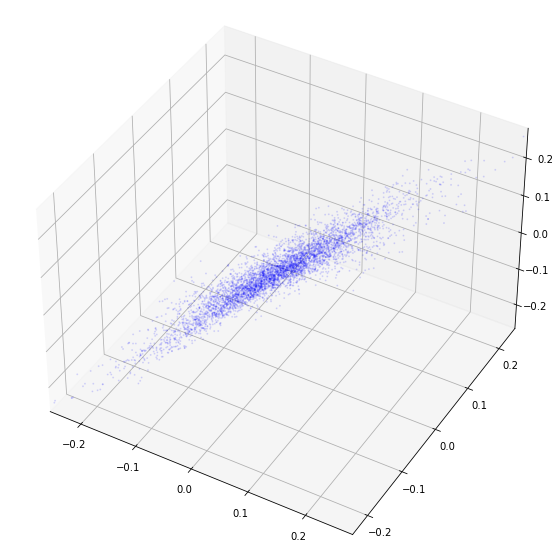

In [5]:
# Tools for interactive 3D visualisation
import ipyvolume as ipv
fig = ipv.figure()
ipv.pylab.xlim(residuals['R'].min(), residuals['R'].max())
ipv.pylab.ylim(residuals['G'].min(), residuals['G'].max())
ipv.pylab.zlim(residuals['B'].min(), residuals['B'].max())
scatter = ipv.scatter(residuals['R'].values, 
                      residuals['G'].values, 
                      residuals['B'].values, 
                      size = 1.5, marker='sphere', c ='blue')
scatter.color = [0., 0, 1.0, 0.2]
scatter.material.transparent = True
ipv.show()

# Tools for non-interactive 3D visualisation
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlim3d(residuals['R'].min(), residuals['R'].max())
ax.set_ylim3d(residuals['G'].min(), residuals['G'].max())
ax.set_ylim3d(residuals['B'].min(), residuals['B'].max())

ax.azim = -60
ax.dist = 10
ax.elev = 40

ax.scatter(residuals['R'], residuals['G'], residuals['B'] , c ='blue', alpha=0.1, s=1)
plt.show()

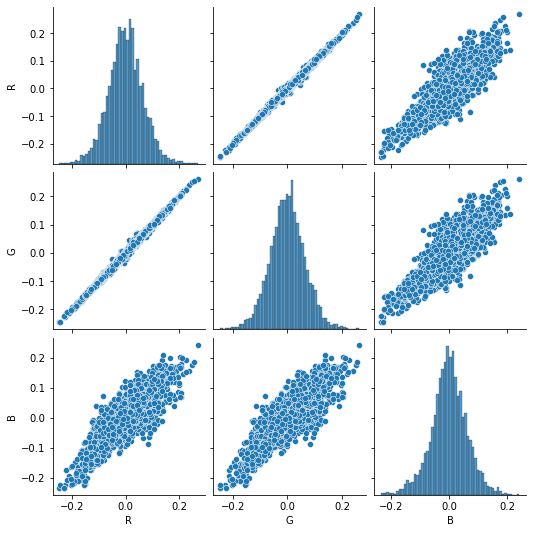

In [6]:
import seaborn as sns
fig = sns.pairplot(residuals)
#fig.savefig("colored-residuals.pdf")

* Let us fit multivariate normal distribution to the residuals and compare simulation with actual data. 
* Visual inspection shows that the corresponding fit is rather good.

In [7]:
# Estimate distribution parameters
mean = np.mean(residuals, axis=0)
cov = np.cov(residuals, rowvar=0)

# Sample simulated residuals
sample = multivariate_normal(mean=mean, cov=cov).rvs(1000) 

fig = ipv.figure()
ipv.pylab.xlim(residuals['R'].min(), residuals['R'].max())
ipv.pylab.ylim(residuals['G'].min(), residuals['G'].max())
ipv.pylab.zlim(residuals['B'].min(), residuals['B'].max())
scatter = ipv.scatter(residuals['R'].values, 
                      residuals['G'].values, 
                      residuals['B'].values, 
                      size = 1.5, marker='sphere', c ='blue')
scatter.color = [0., 0, 1.0, 0.2]
scatter.material.transparent = True
simulation=ipv.scatter(sample[:,0], sample[:, 1], sample[:, 2], size = 2.5, marker='sphere', c ='blue') 
simulation.color = [1., 0.0, 0.0, 1]
simulation.material.transparent = True
ipv.show()

# Homework

## 4.1 Improved vector regression algorithm* (<font color='red'>3p</font>) 

As the empirical analysis shows that errors of different color channels are not independent, we need to alter the probabilistic model. Namely let us consider the following model

\begin{align}
\mathbf{y}_i=A\mathbf{x}_i + \textbf{b}+ \boldsymbol{\varepsilon}_i,\qquad \boldsymbol{\varepsilon}_i\sim\mathcal{N}(\boldsymbol{\mu},\Sigma) 
\end{align}

where $\boldsymbol{y}=(y_1,y_2,y_3)$ is the RGB value of the predicted pixel and $\mathbf{x}$ is the vector RGB intensities of neighbouring pixels. Let us assume that $\boldsymbol{\mu}=\mathbf{0}$ and that $\Sigma$ is correctly predicted from the residuals.

Now you can find model parameters by deriving the expression for the likelyhood $p[\textbf{y}_1,\ldots,\textbf{y}_n|\textbf{x}_1,\ldots,\textbf{x}_n, A, \textbf{b}]$.
However, this is technically difficult. There is a shortcut. If we know how to express

\begin{align*}
\boldsymbol{\varepsilon_i}=R\boldsymbol{\varrho}_i, \qquad \boldsymbol{\varrho}_i\sim\mathcal{N}(0,\mathbf{I}) 
\end{align*}

Then we can revert the roation 

\begin{align}
\mathbf{z}_i=R^{-1}\mathbf{y}_i=R^{-1}A\mathbf{x}_i + R^{-1}\textbf{b}+ \boldsymbol{\varrho}_i,\qquad \boldsymbol{\varepsilon}_i\sim\mathcal{N}(0,\mathbf{I}) 
\end{align}

Then we can solve the ordinary linear regression task for $\mathbf{z}_1,\ldots, \mathbf{z}_n$ and then translate the solution back to original setting. Implement the corresponding regression procedure and show that resulting residuals are trully uncorrelated. Compare the quality of imputation for both models. Can you see the difference.

**Hint:** Principal component analysis takes a data in and finds a rotation such that the rotated data is uncorrelated in each dimension. By setting some flags you can also scale the data so that the variance is equal in each direction. Afer that you can use the corresponding rotation matrix as $R^{-1}$. Further details can be found in the notebook [01_introduction_to_pca.ipynb](../05/01_introduction_to_pca.ipynb). 